# Introduction
We are interested in exploring the ability to predict a borrower’s likelihood to pay back a loan based on available information at the origination of a loan.

This dataset provides us with the loan information from Lending Club, one of the world’s largest peer-to-peer lending platforms ( https://www.kaggle.com/wordsforthewise/lending-club ).The dataset includes important information about a large amount of specific loans. We will use the features, some describing the loan(e.g., the monthly payment and interest rate) while others are about borrowers(e.g., borrowers’ job title and annual income), to **predict whether this loan will be finally paid off**. It is a **binary-classification** task.

# Our Goal
- We will use exploratory data analysis, including statistical analysis and visualization analysis, to extract features that significantly influence the loan status: whether this loan would be paid off. It is a large dataset with millions of loan data and more than 20 features. What’s more, not all features are numerical. Some missing values exists. We will show how we deal with this challenging dataset and make data-driven conclusions.
- We will implement several models for our classification, visualize and explain each followed by comparing their methods and results. Our plan is to include:
 * LDA and Maximum Likelihood Estimation
 * Logistic regression and RandomForest
 * XGBoost
- The amount of loans being paid off is far more than the number of loans that were charged off, so we meet data imbalance problem here. We will try to solve this problem from both the insight of data processing and machine learning model development.
 * Data processing insight: Develop sampling method. We would try both oversampling and down-sampling.
 * Model insight: Adjust the weight of data from different categories in the objective function for model to optimize.
We will make final model evaluation by F1-score, PR or AUC curve instead of accuracy, which is proved meaningless while data imbalance problem exists. Given those scores and our understanding of the approaches, we will attempt to relate their performances to our expectations.

# Our Approach
1. Dataset input
 1. Read the csv file - .csv file is provided by kaggle.com
 1. Remove entries not known at loan initiation
 1. Handle NaN's
    * Columns with a majority of NaN's are removed
    * Entries with NaN are replaced with mean/mode
 1. Remove in-process loans and reduce enumerations to good/bad
1. Separate the data into training and testing sets (X_train/y_train, X_test/y_test)
1. Begin testing models - As this is a 2 class problem (defaults or does not default on loan) - After working through the data, we tried a few different techniques than originally proposed:
 1. LDA
 1. Logistic Regression
 1. PCA+Logistic Regression
 1. Random Forest
 1. XGBoost
1. Improve dataset using oversampling and undersampling techniques - The two classes are roughly 5:1.  While this is not a massive imbalance (ie 1000:1), we would like to see if it improves performance of any of the models.  This will only be done using Logistic Regression to compare results of over/under sampling as a technique
1. Compare results and analyze performance vs expectations/understanding

In [1]:
# import the library
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score
# ignore the warning if any
import warnings
warnings.filterwarnings("ignore")

# set row/columns
pd.options.display.max_columns= None
pd.options.display.max_rows= None
np.set_printoptions(suppress=True)

# Dataset Input
## Read the csv file

In [2]:
# read the dataset
df = pd.read_csv("accepted_2007_to_2018Q4.csv")

In [3]:
# display top 5 rows to see how data looks like
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [4]:
# check the shape
print(df.shape)

(2260701, 151)


## Convert earliest creditline column to months-before-start-of-loan

In [5]:
# earliest_cr_line is a date - convert it into roughly months since epoch
df['earliest_cr_line'] = (pd.to_datetime(df['earliest_cr_line']) - pd.to_datetime(df['issue_d'])) // pd.Timedelta('30days')


## Remove columns that are unnecessary and not available at origination of loan 

In [6]:
# These columns were identified by us as ones either not logically associated, not available at start of loan, or
# not a type of data in a reasonable sequence (ie Zip Code could be an indicator but not as a number - more sophisticated
# analysis would be required across each zip code)
df.drop(['id','member_id','emp_title','issue_d','pymnt_plan','url','desc','title','zip_code','addr_state','delinq_2yrs','mths_since_last_delinq','mths_since_last_record','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','mths_since_last_major_derog','annual_inc_joint','dti_joint','verification_status_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','all_util','total_cu_tl','inq_last_12m','acc_open_past_24mths','chargeoff_within_12_mths','delinq_amnt','mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq','num_accts_ever_120_pd','tax_liens','hardship_flag','hardship_type','hardship_reason','hardship_status','deferral_term','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length','hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount','settlement_percentage','settlement_term'],
          axis=1, inplace=True)

In [7]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,application_type,open_rv_12m,open_rv_24m,max_bal_bc,total_rev_hi_lim,inq_fi,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,5.91,-151.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,1.0,Individual,3.0,3.0,722.0,9300.0,3.0,20701.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,16.06,-195.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,1.0,Individual,2.0,3.0,6472.0,111800.0,0.0,9733.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,10.78,-187.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,1.0,Joint App,0.0,2.0,2081.0,14000.0,2.0,31617.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,17.06,-89.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,1.0,Individual,1.0,1.0,6987.0,67300.0,0.0,23192.0,54962.0,12.1,36.0,87.0,2.0,2.0,1.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,25.37,-214.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1.0,Individual,4.0,7.0,9702.0,34000.0,2.0,27644.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


In [8]:
print(df.shape)

(2260701, 74)


## Replace string columns with obvious mapping to values

In [9]:
df['term'].replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
df['grade'].replace(('A','B','C','D','E','F','G'),(1,2,3,4,5,6,7), inplace = True) 
df['sub_grade'].replace(('A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5'),
                        (1.1, 1.2, 1.3, 1.4, 1.5, 2.1, 2.2, 2.3, 2.4, 2.5, 3.1, 3.2, 3.3, 3.4, 3.5, 4.1, 4.2, 4.3, 4.4, 4.5, 5.1, 5.2, 5.3, 5.4, 5.5, 6.1, 6.2, 6.3, 6.4, 6.5, 7.1, 7.2, 7.3, 7.4, 7.5), inplace = True)
df['emp_length'].replace(('10+ years','2 years','< 1 year','3 years','1 year','5 years','4 years','6 years','8 years','7 years','9 years'),(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,application_type,open_rv_12m,open_rv_24m,max_bal_bc,total_rev_hi_lim,inq_fi,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,3.0,3.4,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,5.91,-151.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,1.0,Individual,3.0,3.0,722.0,9300.0,3.0,20701.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,3.0,3.1,10.0,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,16.06,-195.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,1.0,Individual,2.0,3.0,6472.0,111800.0,0.0,9733.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,2.0,2.4,10.0,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,10.78,-187.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,1.0,Joint App,0.0,2.0,2081.0,14000.0,2.0,31617.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,35000.0,35000.0,35000.0,60.0,14.85,829.90,3.0,3.5,10.0,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation,17.06,-89.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,1.0,Individual,1.0,1.0,6987.0,67300.0,0.0,23192.0,54962.0,12.1,36.0,87.0,2.0,2.0,1.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,6.0,6.1,3.0,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,25.37,-214.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1.0,Individual,4.0,7.0,9702.0,34000.0,2.0,27644.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


## Handle NaN's

### Columnwise, find percentage of NULL Values

In [10]:
percent_df = df.isna().mean()
print(percent_df*100)

loan_amnt                               0.001460
funded_amnt                             0.001460
funded_amnt_inv                         0.001460
term                                    0.001460
int_rate                                0.001460
installment                             0.001460
grade                                   0.001460
sub_grade                               0.001460
emp_length                              6.499754
home_ownership                          0.001460
annual_inc                              0.001637
verification_status                     0.001460
loan_status                             0.001460
purpose                                 0.001460
dti                                     0.077144
earliest_cr_line                        0.002743
fico_range_low                          0.001460
fico_range_high                         0.001460
inq_last_6mths                          0.002787
open_acc                                0.002743
pub_rec             

### filter percentages less than 30%

In [11]:
x = percent_df[percent_df*100>30]   # Means they have more than 30% NANs
print(x.index)
df.drop(labels = x.index, inplace = True, axis = 1)

Index(['open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'inq_fi', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog'],
      dtype='object')


## Remove in-process loans and reduce enumerations to good/bad

In [12]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'policy_code', 'application_type',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total

In [13]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [14]:
df['loan_status'] = df['loan_status'].replace(['Does not meet the credit policy. Status:Fully Paid'],'Fully Paid')

In [15]:
df['loan_status'] = df['loan_status'].replace(['Does not meet the credit policy. Status:Charged Off'],'Charged Off')

In [16]:
df['loan_status'].value_counts()

Fully Paid            1078739
Current                878317
Charged Off            269320
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40
Name: loan_status, dtype: int64

In [17]:
filt_df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [18]:
filt_df.shape

(1348059, 57)

In [19]:
filt_df['loan_status'].value_counts()

Fully Paid     1078739
Charged Off     269320
Name: loan_status, dtype: int64

In [20]:
filt_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,application_type,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,3.0,3.4,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,5.91,-151.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,1.0,Individual,9300.0,20701.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,3.0,3.1,10.0,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,16.06,-195.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,1.0,Individual,111800.0,9733.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,314017.0,39475.0,79300.0,24667.0,Cash
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,2.0,2.4,10.0,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,10.78,-187.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,1.0,Joint App,14000.0,31617.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,6.0,6.1,3.0,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,25.37,-214.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1.0,Individual,34000.0,27644.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash
5,11950.0,11950.0,11950.0,36.0,13.44,405.18,3.0,3.3,4.0,RENT,34000.0,Source Verified,Fully Paid,debt_consolidation,10.20,-343.0,690.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,1.0,Individual,12900.0,2560.0,844.0,91.0,338.0,54.0,32.0,32.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,16900.0,12798.0,9400.0,4000.0,Cash


# NAN Treatment

In [21]:
filt_df.isna().mean()

loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_length                    0.058265
home_ownership                0.000000
annual_inc                    0.000003
verification_status           0.000000
loan_status                   0.000000
purpose                       0.000000
dti                           0.000277
earliest_cr_line              0.000022
fico_range_low                0.000000
fico_range_high               0.000000
inq_last_6mths                0.000022
open_acc                      0.000022
pub_rec                       0.000022
revol_bal                     0.000000
revol_util                    0.000665
total_acc                     0.000022
initial_list_status           0.000000
policy_code              

## Fill in n/a cells with reasonable information

In [22]:
cat_col = list(filt_df.select_dtypes('object'))            #all strings
num_col = list(filt_df.select_dtypes('float64'))                   #all floats

## Replace numerical n/a cells with mean for the column

In [23]:
x = filt_df[num_col].isna().mean()

In [24]:
# Look at percentage of na cells before filling
x

loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_length                    0.058265
annual_inc                    0.000003
dti                           0.000277
earliest_cr_line              0.000022
fico_range_low                0.000000
fico_range_high               0.000000
inq_last_6mths                0.000022
open_acc                      0.000022
pub_rec                       0.000022
revol_bal                     0.000000
revol_util                    0.000665
total_acc                     0.000022
policy_code                   0.000000
total_rev_hi_lim              0.052131
avg_cur_bal                   0.052148
bc_open_to_buy                0.047396
bc_util                       0.047966
mo_sin_old_il_acct       

In [25]:
x[x>0].index 

Index(['emp_length', 'annual_inc', 'dti', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'total_rev_hi_lim',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'],
      dtype='object')

In [26]:
nan_columns = x[x>0].index 
# write the columns to variable   #type(nan_columns)

In [27]:
filt_df['num_sats'].isna().sum()

58590

In [28]:
filt_df['num_sats'].fillna(filt_df['num_sats'].mean()).head() #replace num_stats NAN values with mean values

0     7.0
1    22.0
2     6.0
4    12.0
5     5.0
Name: num_sats, dtype: float64

In [29]:
for col in nan_columns:
    filt_df[col] = filt_df[col].fillna(filt_df[col].mean())   # replace nan columns with mean values

In [30]:
# Look at na columns after filling - all should be zero
filt_df[nan_columns].isna().sum()          # All nan columns have become 0

emp_length                    0
annual_inc                    0
dti                           0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
total_rev_hi_lim              0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_rcnt_rev_tl_op         0
mo_sin_rcnt_tl                0
mort_acc                      0
num_actv_bc_tl                0
num_actv_rev_tl               0
num_bc_sats                   0
num_bc_tl                     0
num_il_tl                     0
num_op_rev_tl                 0
num_rev_accts                 0
num_rev_tl_bal_gt_0           0
num_sats                      0
num_tl_120dpd_2m              0
num_tl_30dpd                  0
num_tl_90g_dpd_24m            0
num_tl_op_past_12m            0
pct_tl_n

## Replace n/a object cells with mode

In [31]:
for col in cat_col:
    filt_df[col] = filt_df[col].fillna(filt_df[col].mode())  # Replace cat_col using mode

In [32]:
filt_df[cat_col].isna().sum()

home_ownership         0
verification_status    0
loan_status            0
purpose                0
initial_list_status    0
application_type       0
disbursement_method    0
dtype: int64

In [33]:
filt_df.select_dtypes('object').columns

Index(['home_ownership', 'verification_status', 'loan_status', 'purpose',
       'initial_list_status', 'application_type', 'disbursement_method'],
      dtype='object')

In [34]:
filt_df.isna().mean()*100

loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
int_rate                      0.0
installment                   0.0
grade                         0.0
sub_grade                     0.0
emp_length                    0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
loan_status                   0.0
purpose                       0.0
dti                           0.0
earliest_cr_line              0.0
fico_range_low                0.0
fico_range_high               0.0
inq_last_6mths                0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
revol_util                    0.0
total_acc                     0.0
initial_list_status           0.0
policy_code                   0.0
application_type              0.0
total_rev_hi_lim              0.0
avg_cur_bal                   0.0
bc_open_to_buy

In [35]:
filt_df.shape   #All objects sorted

(1348059, 57)

## Convert remaining categorical values to boolean columns

In [36]:
filt_df[cat_col].nunique()

home_ownership          6
verification_status     3
loan_status             2
purpose                14
initial_list_status     2
application_type        2
disbursement_method     2
dtype: int64

In [37]:
# View first records before converting to boolean columns
filt_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,application_type,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,3.0,3.4,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,5.91,-151.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,1.0,Individual,9300.0,20701.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,3.0,3.1,10.0,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,16.06,-195.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,1.0,Individual,111800.0,9733.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,314017.0,39475.0,79300.0,24667.0,Cash
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,2.0,2.4,10.0,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,10.78,-187.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,1.0,Joint App,14000.0,31617.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,6.0,6.1,3.0,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,25.37,-214.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1.0,Individual,34000.0,27644.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash
5,11950.0,11950.0,11950.0,36.0,13.44,405.18,3.0,3.3,4.0,RENT,34000.0,Source Verified,Fully Paid,debt_consolidation,10.20,-343.0,690.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,1.0,Individual,12900.0,2560.0,844.0,91.0,338.0,54.0,32.0,32.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,16900.0,12798.0,9400.0,4000.0,Cash


In [38]:
# Convert each column to a set of columns with 1/0 for each possible value
#from tqdm import tqdm
import re
for col_i in range(len(cat_col)):
    col = cat_col[col_i]
    unique_values = filt_df[col].unique()
    for i in range(len(unique_values)):
        #new_column = re.sub(r'\W+', '', col + '_' + str(unique_values[i]))
        new_column = re.sub(r' ', '_', col + '_' + str(unique_values[i]))
        filt_df[new_column] = filt_df[col].eq(unique_values[i]) * 1.0
    filt_df.drop(col,axis=1,inplace=True)
    #filt_df[col] = filt_df[col].replace(filt_df[col].unique(),list(range(len(filt_df[col].unique()))))

In [39]:
# View first rows after converting to numerical columns
filt_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_RENT,home_ownership_OWN,home_ownership_ANY,home_ownership_NONE,home_ownership_OTHER,verification_status_Not_Verified,verification_status_Source_Verified,verification_status_Verified,loan_status_Fully_Paid,loan_status_Charged_Off,purpose_debt_consolidation,purpose_small_business,purpose_home_improvement,purpose_major_purchase,purpose_credit_card,purpose_other,purpose_house,purpose_vacation,purpose_car,purpose_medical,purpose_moving,purpose_renewable_energy,purpose_wedding,purpose_educational,initial_list_status_w,initial_list_status_f,application_type_Individual,application_type_Joint_App,disbursement_method_Cash,disbursement_method_DirectPay
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,3.0,3.4,10.0,55000.0,5.91,-151.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1.0,9300.0,20701.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,178050.0,7746.0,2400.0,13734.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,3.0,3.1,10.0,65000.0,16.06,-195.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,1.0,111800.0,9733.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,314017.0,39475.0,79300.0,24667.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,2.0,2.4,10.0,63000.0,10.78,-187.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,1.0,14000.0,31617.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,218418.0,18696.0,6200.0,14877.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,6.0,6.1,3.0,104433.0,25.37,-214.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1.0,34000.0,27644.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,439570.0,95768.0,20300.0,88097.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,11950.0,11950.0,11950.0,36.0,13.44,405.18,3.0,3.3,4.0,34000.0,10.20,-343.0,690.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,1.0,12900.0,2560.0,844.0,91.0,338.0,54.0,32.0,32.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,16900.0,12798.0,9400.0,4000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [40]:
filt_df.shape

(1348059, 81)

# Define X and y (independent and dependent features for model creation )

In [41]:
# Drop loan status from inputs
X = filt_df.drop(['loan_status_Fully_Paid','loan_status_Charged_Off'],axis=1) #other than loan status

In [42]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'annual_inc', 'dti',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'policy_code', 'total_rev_hi_lim', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'home_ownership_MORTGAGE', 'home_ownership_RENT', 'home_ownership_OW

In [43]:
y=filt_df['loan_status_Fully_Paid']

In [44]:
# training and test set splitting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get x and y
# x = df_copy.drop(columns='loan_status',axis=1)
# y = df_copy['loan_status']

# feature scaling to bring the features into same range
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split the data. 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, shuffle = True)

In [45]:
import sklearn

In [46]:
sklearn.__version__

'1.1.2'

In [47]:
# Results
f1_results = []

# Training and testing the models
* LDA
* Logistic Regression
* PCA+Logistic Regression
* Random Forest
* XGBoost
Apply undersampling and oversampling then retrain models

## LDA

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[  9128,  71653],
       [  8722, 314915]])

In [49]:
# Store off results
f1_results.append({
    'Name':'LDA', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_pred), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_pred)})
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.11      0.19     80781
         1.0       0.81      0.97      0.89    323637

    accuracy                           0.80    404418
   macro avg       0.66      0.54      0.54    404418
weighted avg       0.75      0.80      0.75    404418



## Logistic Regression

In [50]:
# build the model
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state= 42)

# fit the model on training data
lr_model.fit(X_train,y_train)

# make prediction on test data
y_pred = lr_model.predict(X_test)

In [51]:
out = pd.DataFrame({'Y_True':y_test,'y_Pred':y_pred})

In [52]:
confusion_matrix(y_test,y_pred)

array([[  7076,  73705],
       [  6272, 317365]])

In [53]:
# Store off results
f1_results.append({
    'Name':'Logistic Reg', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_pred), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_pred)})
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

         0.0       0.53      0.09      0.15     80781
         1.0       0.81      0.98      0.89    323637

    accuracy                           0.80    404418
   macro avg       0.67      0.53      0.52    404418
weighted avg       0.76      0.80      0.74    404418



In [54]:
accuracy_score(y_test,y_pred)

0.8022417399819

## PCA + Logistic Regression

In [55]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [56]:
X_train_pca.shape

(943641, 10)

In [57]:
X_test_pca.shape

(404418, 10)

In [58]:
y_train.shape

(943641,)

In [59]:
# build the model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state= 42)

# fit the model on training data
lr_model.fit(X_train_pca,y_train)

# make prediction on test data
y_lr_pred = lr_model.predict(X_test_pca)

In [60]:
# Store off results
f1_results.append({
    'Name':'PCA+Log Reg', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_lr_pred), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_lr_pred)})
print(classification_report(y_test,y_lr_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.06      0.11     80781
         1.0       0.81      0.99      0.89    323637

    accuracy                           0.80    404418
   macro avg       0.67      0.52      0.50    404418
weighted avg       0.75      0.80      0.73    404418



## Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=10)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

In [62]:
# Store off results
f1_results.append({
    'Name':'RandomForest', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_rf_pred), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_rf_pred)})
print(classification_report(y_test,y_rf_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.02      0.05     80781
         1.0       0.80      1.00      0.89    323637

    accuracy                           0.80    404418
   macro avg       0.71      0.51      0.47    404418
weighted avg       0.77      0.80      0.72    404418



## XGBoost

In [63]:
import xgboost as xgb
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
num_round = 40
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_model = xgb.XGBClassifier()
xgb_model_trained = xgb_model.fit(X_train, y_train)

In [64]:
y_pred_xgb = xgb_model_trained.predict(X_test)

In [65]:
# Store off results
f1_results.append({
    'Name':'XGBoost', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_pred_xgb), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_pred_xgb)})
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.56      0.11      0.18     80781
         1.0       0.81      0.98      0.89    323637

    accuracy                           0.80    404418
   macro avg       0.69      0.54      0.53    404418
weighted avg       0.76      0.80      0.75    404418



# Over/Undersampling
Apply oversampling and undersampling and train a logistic regression model to observe impact of balancing the samples
## Oversampling

In [66]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
# X_train, y_train = smt.fit_resample(X_train, y_train)

# smt = SMOTE(sampling_strategy=0.2)
X_smote, y_smote = smt.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='loan_status_Fully_Paid', ylabel='count'>

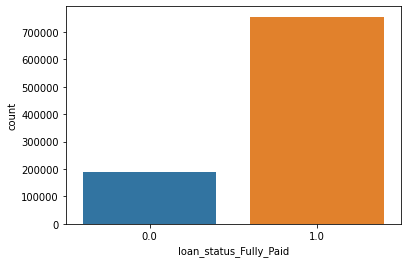

In [67]:
sns.countplot(y_train)

<AxesSubplot:xlabel='loan_status_Fully_Paid', ylabel='count'>

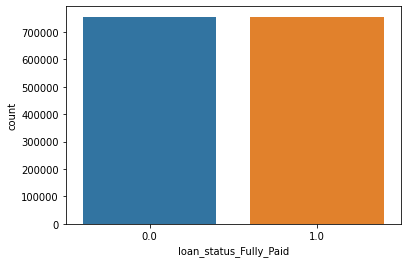

In [68]:
sns.countplot(y_smote)

In [69]:
# build the model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state= 42)

# fit the model on training data
lr_model.fit(X_smote,y_smote)

# make prediction on test data
y_pred_smote = lr_model.predict(X_test)

In [70]:
X_smote.shape

(1510204, 79)

In [71]:
y_smote.shape

(1510204,)

In [72]:
confusion_matrix(y_test,y_pred_smote)

array([[ 52375,  28406],
       [109534, 214103]])

In [73]:
f1_results.append({
    'Name':'Oversample-LR', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_pred_smote), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_pred_smote)})
print(classification_report(y_test,y_pred_smote))


              precision    recall  f1-score   support

         0.0       0.32      0.65      0.43     80781
         1.0       0.88      0.66      0.76    323637

    accuracy                           0.66    404418
   macro avg       0.60      0.65      0.59    404418
weighted avg       0.77      0.66      0.69    404418



## Undersampling

In [74]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_under, y_under = undersampler.fit_resample(X_train, y_train)

In [75]:
X_train.shape

(943641, 79)

In [76]:
X_under.shape

(377078, 79)

In [77]:
# build the model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state= 42)

# fit the model on training data
lr_model.fit(X_under, y_under)

# make prediction on test data
y_pred_under = lr_model.predict(X_test)

In [78]:
confusion_matrix(y_test,y_pred_under)

array([[ 52383,  28398],
       [108545, 215092]])

In [79]:
f1_results.append({
    'Name':'Undersample-LR', 
    'f1-pos':sklearn.metrics.f1_score(y_test, y_pred_under), 
    'f1-neg':sklearn.metrics.f1_score(1-y_test, 1-y_pred_under)})
print(classification_report(y_test,y_pred_under))

              precision    recall  f1-score   support

         0.0       0.33      0.65      0.43     80781
         1.0       0.88      0.66      0.76    323637

    accuracy                           0.66    404418
   macro avg       0.60      0.66      0.60    404418
weighted avg       0.77      0.66      0.69    404418



# Results

In [80]:
# Look at cumulative results
# Pos -> Loan Paid completely
# Neg -> Load defaulted
pd.DataFrame(f1_results)

,Name,f1-pos,f1-neg
0,LDA,0.886828,0.185094
1,Logistic Reg,0.888098,0.150347
2,PCA+Log Reg,0.888243,0.107800
3,RandomForest,0.889563,0.045632
4,XGBoost,0.889304,0.179788
5,Oversample-LR,0.756353,0.431621
6,Undersample-LR,0.758532,0.433439
